**add_messages** --> ```Reducers```

1. 
Reducers in State Management:

In LangGraph, you can define a special function called a reducer for each field in your State.
A State is a data structure that holds the current state of your application or system.


2. 
Purpose of a Reducer:

When you return a new State, LangGraph uses the reducer to combine the new value of a specific field with the existing value of that field in the current State.
This ensures that the new value is merged or combined with the existing value, rather than completely overwriting it.


3. 
Concurrency and State Combination:

The use of reducers enables LangGraph to run multiple nodes (or processes) concurrently.
Even when multiple nodes are updating the State simultaneously, the reducers ensure that the updates are combined properly without causing data loss or conflicts.



Summary:

* Append new messages
* A reducer is a function that defines how a specific field in the State should be updated when a new value is returned.
* LangGraph uses reducers to merge new state values with existing ones, preventing overwriting.
* This mechanism supports concurrent execution of multiple nodes, allowing them to update the State without conflicts.

In essence, reducers provide a way to manage state updates in a controlled and conflict-free manner, especially in systems where multiple processes or nodes are updating the state simultaneously.

```
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
```

Explanation: Before building the graph, this code demonstrates how the **add_messages** function works. This is a **reducer**.

Input 1: A list of existing messages (Oscar says Hi, AI answers).

Input 2: A specific update (Oscar asks for news).

Result: add_messages does not replace the list; it appends the new message to the end. **not Overwrite**

This single line of code is the engine that manages the "memory" of your application. It tells LangGraph two specific things:

1. What data to store.
2. How to update that data when a node returns new information.

Let's break it down into its three components.
1. ```class State(TypedDict)```
This creates a blueprint for a dictionary. It tells Python that the state of your graph is just a standard dictionary, but it enforces a specific structure.

* Structure: {"messages": ...}

2. ```Sequence[BaseMessage]```
This defines the Data Type.

* It says that the value stored under the key "messages" must be a list (Sequence) containing message objects.
* BaseMessage is the parent class for HumanMessage, AIMessage, SystemMessage, etc.

3. ```Annotated[..., add_messages]``` (The Magic Part)
This is where LangGraph specific logic happens. The Annotated type takes two arguments: Annotated[T, reducer].


* ```The Type: Sequence[BaseMessage]```
* ```The Reducer: add_messages```

What is a Reducer?
In standard Python dictionaries, if you update a key, it overwrites the old value.
pythonDownloadCopy code# Standard Dictionary Behavior (Overwriting)
state = {"messages": ["Hello"]}
new_data = {"messages": ["World"]}
state.update(new_data)
Result: state is now {"messages": ["World"]} -> "Hello" is lost!
However, because we used Annotated[..., add_messages], LangGraph changes this behavior to Appending (Merging).
When a node returns a new State, LangGraph sees the add_messages instruction and thinks: "Don't delete the old messages. ADD the new ones to the existing list."

* **Summary**
Without Annotated[..., add_messages], the chatbot node would overwrite the HumanMessage, and the AI would forget what the user just said.
With add_messages, the list grows longer at every step, preserving the conversation history automatically.

In [6]:
import os
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.chains import LLMChain
from langgraph.graph import START, END, StateGraph, add_messages
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.runnables import Runnable
from collections.abc import Sequence
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from collections.abc import Sequence
from typing import Literal, Annotated


In [2]:
# Use dotenv to load your environment variables (if running in Jupyter, `%dotenv` is fine)
from dotenv import load_dotenv
load_dotenv()  # loads .env file into environment variables
# Confirm your key is loaded
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("OPENAI_API_KEY not found in environment variables")
print(f"OPENAI_API_KEY loaded: {'Yes' if api_key else 'No'}")

OPENAI_API_KEY loaded: Yes


In [11]:
llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.3, max_tokens=25)

In [ ]:
llm.invoke("what model i use now?")

AIMessage(content="You are currently interacting with OpenAI's GPT-", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 13, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CecJZCmOseu6Npw1QRy8xpOgm6fmk', 'service_tier': 'default', 'finish_reason': 'length', 'logprobs': None}, id='run--0837e21a-0e58-4d24-aaf4-c783bf2b3513-0', usage_metadata={'input_tokens': 13, 'output_tokens': 10, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
my_list = add_messages([HumanMessage("Hi! I'm Oscar."), 
                        AIMessage("Hey, Oscar. How can I assist you?")],
                       [HumanMessage("Could you summarize today's news?")])

In [8]:
my_list

[HumanMessage(content="Hi! I'm Oscar.", additional_kwargs={}, response_metadata={}, id='56339db1-2bab-4ccb-b93c-c8f30b1949a2'),
 AIMessage(content='Hey, Oscar. How can I assist you?', additional_kwargs={}, response_metadata={}, id='e0235d09-6ce9-458f-8213-f4f6dfe40a7b'),
 HumanMessage(content="Could you summarize today's news?", additional_kwargs={}, response_metadata={}, id='a40c0dec-279f-4eea-91d7-9f6709715662')]

In [9]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
def ask_question(state: State) -> State:
    print(f"\n-------> ENTERING ask_question:")
    print("what is your question?")

    return State(messages= [HumanMessage(input())])

In [ ]:
def chatbot(state: State) -> State:
    print(f"\n-------> ENTERING chatbot:")
    
    response = llm.invoke(state['messages'])
    response.pretty_print()

    return State(messages=['response'])

In [14]:
def ask_another_question(state: State) -> State:
    print(f"\n-------> ENTERING ask_another_question:")
    print("Would you like to ask one more question (yes/no)?")

    return State(messages=[HumanMessage(input())])

In [24]:
def routing_function(state: State) -> Literal['ask_question', "__end__"]:
    # Change [0] to [-1] to check the MOST RECENT user input
    last_message = state['messages'][-1]
    
    # .lower() makes it work for "Yes", "YES", or "yes"
    if last_message.content.lower() == "yes":
        return "ask_question"
    else:
        return "__end__"

In [25]:
graph = StateGraph(State)

graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question","chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges("ask_another_question", routing_function)
graph_builder = graph.compile()

In [26]:
graph_builder.invoke(State(messages=[]))


-------> ENTERING ask_question:
what is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

Intelligent automation.

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?

-------> ENTERING ask_question:
what is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

The "best" large language model (LLM) can vary depending on specific use cases and requirements. Some of the most

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


{'messages': [HumanMessage(content='what is ai in 2 words?', additional_kwargs={}, response_metadata={}, id='01e77492-5242-43c6-8f20-e8c098f0f204'),
  AIMessage(content='Intelligent automation.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 15, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CeeJTFZ0FjErKApbsOeWbT0MxDeHA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a59fdb78-5822-4caa-b969-a3f2fb079037-0', usage_metadata={'input_tokens': 15, 'output_tokens': 4, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='yes

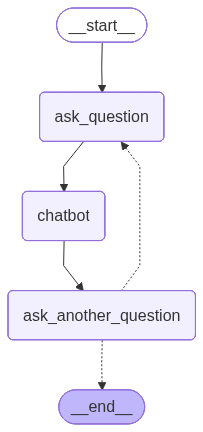

In [27]:
from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))